In [14]:
%config Completer.use_jedi = False

In [1]:
# data analysis
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Forecasting
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly


ModuleNotFoundError: No module named 'fbprophet'

In [6]:
cash = pd.read_csv('train.csv')
cash.head()

,periode,cash_in_echannel,cash_out_echannel,cash_in_kantor,cash_out_kantor,cr_ketetapan_total_bkn_sum,giro,deposito,kewajiban_lain,tabungan,rata_dpk_mingguan,kas_kantor,kas_echannel
0,2019-07-31,7.303000e+08,-1.304400e+09,1.436722e+11,-1.106104e+11,3.0,9.867358e+11,8.048153e+11,1.419685e+10,7.072647e+11,3.135744e+11,1.928940e+09,2.939100e+09
1,2019-08-01,7.322000e+08,-8.321500e+08,3.144131e+11,-6.710987e+10,3.0,8.962459e+11,8.125611e+11,1.234062e+10,7.011995e+11,3.135744e+11,2.492322e+11,2.839150e+09
2,2019-08-02,1.169800e+09,-6.214000e+08,1.251294e+09,-1.142332e+09,3.0,9.059714e+11,8.127225e+11,1.182022e+10,6.922787e+11,3.135744e+11,2.493411e+11,3.387550e+09
3,2019-08-03,9.134500e+08,-4.240500e+08,0.000000e+00,0.000000e+00,3.0,9.057127e+11,8.127253e+11,1.199640e+10,6.867224e+11,3.135744e+11,2.493411e+11,3.876950e+09
4,2019-08-04,7.752500e+08,-7.779500e+08,9.883331e+10,-8.729274e+10,3.0,9.788347e+11,8.124711e+11,1.232962e+10,6.813438e+11,3.135744e+11,2.608817e+11,3.874250e+09


In [7]:
cash['periode'] = pd.to_datetime(cash['periode'])
cash.sort_values('periode', inplace=True)
cash['kas_kantor_verif'] = cash['kas_kantor'].shift()+cash['cash_in_kantor'] + cash['cash_out_kantor']
cash['kas_echannel_verif'] = cash['kas_echannel'].shift()+cash['cash_in_echannel'] + cash['cash_out_echannel']

# Data Visualization

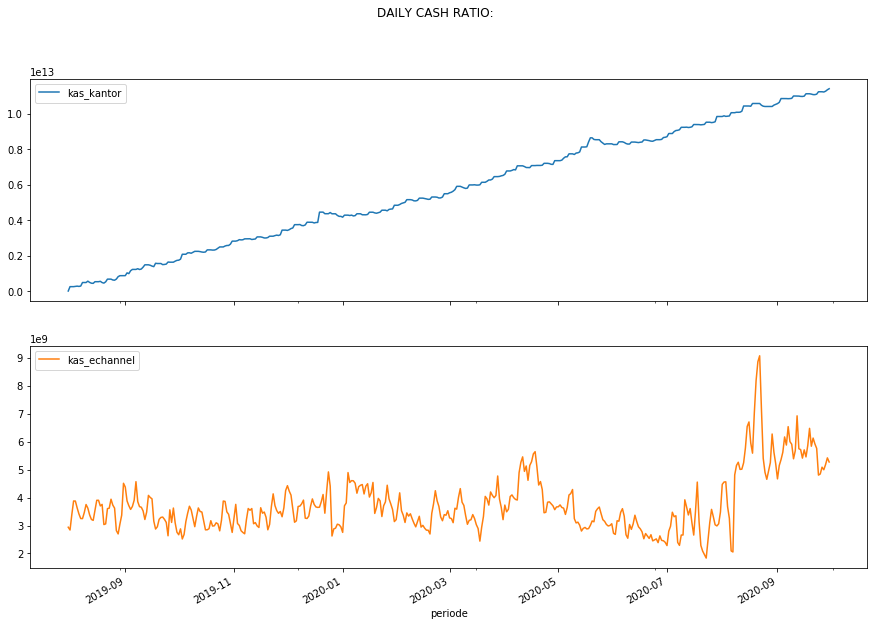

In [8]:
cash.set_index('periode')[['kas_kantor', 'kas_echannel']].plot(subplots=True,
                                                                      figsize=(15, 10))
plt.suptitle('DAILY CASH RATIO:')
plt.show()

# Data Preparation for Prophet

In [9]:
daily_kas_kantor = cash[['periode', 'kas_kantor']].rename(
    columns={'periode': 'ds',
             'kas_kantor': 'y'})

# Take 80% data for training

# daily_kas_kantor = cash[['periode', 'kas_kantor']].head(int(len(cash)*(80/100))).rename(
#     columns={'periode': 'ds',
#              'kas_kantor': 'y'})

daily_kas_kantor.head()

,ds,y
0,2019-07-31,1.928940e+09
1,2019-08-01,2.492322e+11
2,2019-08-02,2.493411e+11
3,2019-08-03,2.493411e+11
4,2019-08-04,2.608817e+11


In [10]:
daily_kas_echannel = cash[['periode', 'kas_echannel']].rename(
    columns={'periode': 'ds',
             'kas_echannel': 'y'})
# daily_kas_echannel = cash[['periode', 'kas_echannel']].head(int(len(cash)*(80/100))).rename(
#     columns={'periode': 'ds',
#              'kas_echannel': 'y'})

daily_kas_echannel.head()

,ds,y
0,2019-07-31,2.939100e+09
1,2019-08-01,2.839150e+09
2,2019-08-02,3.387550e+09
3,2019-08-03,3.876950e+09
4,2019-08-04,3.874250e+09


# Prophet Kas Kantor

## Initiate Custom Holiday

In [11]:
Covid = pd.DataFrame({
    'holiday': 'Covid',
    'ds': pd.to_datetime(['2020-05-19']), # future date, to be forecasted
    'lower_window': -1, # include 27th - 31st December
    'upper_window': 1})

Kemerdekaan = pd.DataFrame({
    'holiday': 'Kemerdekaan',
    'ds': pd.to_datetime(['2020-08-17']), # future date, to be forecasted
    'lower_window': -1, # include 27th - 31st December
    'upper_window': 1})

Natal = pd.DataFrame({
    'holiday': 'Natal',
    'ds': pd.to_datetime(['2020-12-25', # past date, historical data 
                          '2021-12-25']), # future date, to be forecasted
    'lower_window': -10, # include 27th - 31st December
    'upper_window': 0})

holiday_kantor = pd.concat([Covid,Kemerdekaan,Natal], axis=0).reset_index(drop=True)
holiday_kantor

,holiday,ds,lower_window,upper_window
0,Covid,2020-05-19,-1,1
1,Kemerdekaan,2020-08-17,-1,1
2,Natal,2020-12-25,-10,0
3,Natal,2021-12-25,-10,0


## Prepare Model

In [13]:
model_holiday_indo_kantor = Prophet(weekly_seasonality=3,
                                    yearly_seasonality=10,
#                                       holidays=holiday_kantor,
                                      changepoint_range=0.8, # default = 0.8 Recommended range: [0.8, 0.95]
                                      changepoint_prior_scale=0.095 # default =0.05 Recommended range: [0.001, 0.5]
                                     )
model_holiday_indo_kantor.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_holiday_indo_kantor.add_country_holidays(country_name='ID')
model_holiday_indo_kantor.fit(daily_kas_kantor)

# forecasting
future_kantor = model_holiday_indo_kantor.make_future_dataframe(periods=31, freq='D')
forecast_kantor = model_holiday_indo_kantor.predict(future_kantor)

# visualize
model_holiday_indo_kantor.train_holiday_names

NameError: name 'Prophet' is not defined

In [ ]:
plot_plotly(model_holiday_indo_kantor, forecast_kantor)

In [ ]:
plot_components_plotly(model_holiday_indo_kantor, forecast_kantor)

## Count Error

In [424]:
from sklearn.metrics import mean_squared_log_error
np.sqrt(mean_squared_log_error(forecast_kantor['yhat'].head(425),daily_kas_kantor.loc[:,'y']))


0.1164837791122023

## HyperParameter Tuning Ekantor

In this section, we implement a **Grid search algorithm** for model tuning by using for-loop. It builds model for every combination from specified hyperparameters and then evaluate it. The goal is to choose a set of optimal hyperparameters which minimize the forecast error (in this case, smallest RMSLE).

💡 You can use the code template below, please change it as needed in the section marked by `TO DO`.


Click [here](https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning) for a list of recommended hyperparameters to be tuned.

In [428]:
daily_kas_kantor

,ds,y
0,2019-07-31,1.928940e+09
1,2019-08-01,2.492322e+11
2,2019-08-02,2.493411e+11
3,2019-08-03,2.493411e+11
4,2019-08-04,2.608817e+11
...,...,...
420,2020-09-26,1.123736e+13
421,2020-09-27,1.122373e+13
422,2020-09-28,1.126813e+13
423,2020-09-29,1.134856e+13


In [429]:
from tqdm import tqdm
import itertools
from fbprophet.diagnostics import cross_validation


# Grid search parameters (TO DO: specify possible values)
param_grid = {  
    'changepoint_prior_scale': [0.004, 0.005, 0.006],
    'changepoint_range': [0.8, 0.85, 0.94, 0.95],
    'weekly_seasonality': [3,4,5],
    'yearly_seasonality': [9,10,11]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmsles = []  # Store the RMSLEs for each params here

In [430]:
len(all_params)

108

In [435]:


# Use cross validation to evaluate all parameters
for params in tqdm(all_params):
    # fitting model
    # (TO DO: change the data and add other components: seasonality, holiday, regressor)
    
    model_ekantor_hyperparameter = Prophet(**params)
    model_ekantor_hyperparameter.add_country_holidays(country_name='ID')
    model_ekantor_hyperparameter.add_seasonality(name='monthly', period=30.5, fourier_order=11)
    model_ekantor_hyperparameter.fit(daily_kas_kantor)

    # forecasting
    forecast_ekantor_hyperparameter = model_ekantor_hyperparameter.predict(future_kantor)

    # Expanding window cross validation (TO DO: use different values)
    cv = cross_validation(model_ekantor_hyperparameter, initial='110 days', period='5 days', horizon='7 days',
                        parallel='processes')

    # Evaluation metrics: RMSLE
    try:
        rmsle = cv.groupby('cutoff').apply(lambda x: mean_squared_log_error(y_true=x['y'],y_pred=x['yhat']) ** 0.5)
        mean_rmsle = rmsle.mean()
        rmsles.append(mean_rmsle)
    except:
        rmsles.append(1)
        continue
        
        

    
    
    

  0%|                                                                                          | 0/108 [00:00<?, ?it/s]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000019C91CF9E48>
  1%|▊                                                                                 | 1/108 [00:18<33:04, 18.54s/it]INFO:fbproph

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000019C93563CC8>
  8%|██████▊                                                                           | 9/108 [02:47<30:59, 18.79s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 20

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000019C92F2CF08>
 16%|████████████▊                                                                    | 17/108 [05:18<28:30, 18.79s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in para

 23%|██████████████████▊                                                              | 25/108 [07:48<26:07, 18.89s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000019C93115B48>
 24%|███████████████████▌                                                             | 26/108 [08:08<26:01, 19.05s/it]INFO:fbproph

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000019C9222EE88>
 31%|█████████████████████████▌                                                       | 34/108 [10:38<23:11, 18.81s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 20

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000019C9310C688>
 39%|███████████████████████████████▌                                                 | 42/108 [13:09<20:46, 18.88s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in para

 46%|█████████████████████████████████████▌                                           | 50/108 [15:41<18:25, 19.06s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000019C92E79D48>
 47%|██████████████████████████████████████▎                                          | 51/108 [16:00<18:02, 18.99s/it]INFO:fbproph

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000019C935B5288>
 55%|████████████████████████████████████████████▎                                    | 59/108 [18:48<17:28, 21.40s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 20

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000019C91F383C8>
 62%|██████████████████████████████████████████████████▎                              | 67/108 [21:20<13:03, 19.12s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in para

 69%|████████████████████████████████████████████████████████▎                        | 75/108 [23:52<10:27, 19.00s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000019C92F0C208>
 70%|█████████████████████████████████████████████████████████                        | 76/108 [24:11<10:09, 19.03s/it]INFO:fbproph

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000019C9312FAC8>
 78%|███████████████████████████████████████████████████████████████                  | 84/108 [26:44<07:36, 19.01s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 20

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000019C92259608>
 85%|█████████████████████████████████████████████████████████████████████            | 92/108 [29:16<05:05, 19.12s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in para

 93%|██████████████████████████████████████████████████████████████████████████      | 100/108 [31:49<02:32, 19.12s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000019C931F9708>
 94%|██████████████████████████████████████████████████████████████████████████▊     | 101/108 [32:09<02:15, 19.29s/it]INFO:fbproph

In [436]:
tuning_results = pd.DataFrame(all_params)
tuning_results['rmsle'] = rmsles
tuning_results.sort_values(by='rmsle')

,changepoint_prior_scale,changepoint_range,weekly_seasonality,yearly_seasonality,rmsle
10,0.004,0.85,3,10,0.025659
13,0.004,0.85,4,10,0.025861
28,0.004,0.95,3,10,0.026854
19,0.004,0.94,3,10,0.027115
1,0.004,0.80,3,10,0.027135
...,...,...,...,...,...
86,0.006,0.85,4,11,0.033917
80,0.006,0.80,5,11,0.034624
96,0.006,0.94,5,9,0.034725
101,0.006,0.95,3,11,0.034902


In [437]:
best_params = all_params[np.argmin(rmsles)]
best_params

{'changepoint_prior_scale': 0.004,
 'changepoint_range': 0.85,
 'weekly_seasonality': 3,
 'yearly_seasonality': 10}

In [442]:
model_best_kantor = Prophet(**best_params)
model_best_kantor.add_country_holidays(country_name='ID')
model_best_kantor.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_best_kantor.fit(daily_kas_kantor)


forecast_ekantor_best = model_best_kantor.predict(future_kantor)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019



In [443]:
#Visualize Result
plot_plotly(model_best_kantor, forecast_ekantor_best)


In [444]:
# Error with regressor
from sklearn.metrics import mean_squared_log_error
np.sqrt(mean_squared_log_error(daily_kas_kantor.loc[:,'y'], forecast_ekantor_best['yhat'].head(425)))


0.14400166384415725

# Prophet Kas E-Channel

## Initiate Custom Holiday

In [373]:
Kemerdekaan = pd.DataFrame({
    'holiday': 'Kemerdekaan',
    'ds': pd.to_datetime(['2020-08-19', # past date, historical data 
                          '2021-08-19']), # future date, to be forecasted
    'lower_window': 0, # include 27th - 31st December
    'upper_window': 4})

Natal = pd.DataFrame({
    'holiday': 'Natal',
    'ds': pd.to_datetime(['2020-12-25', # past date, historical data 
                          '2021-12-25']), # future date, to be forecasted
    'lower_window': -1, # include 27th - 31st December
    'upper_window': 6})

Nyepi = pd.DataFrame({
    'holiday': 'Nyepi',
    'ds': pd.to_datetime(['2020-03-25', # past date, historical data 
                          '2021-03-14']), # future date, to be forecasted
    'lower_window': 0, # include 27th - 31st December
    'upper_window': 1})


holiday_echannel = pd.concat([Kemerdekaan,Natal, Nyepi], axis=0).reset_index(drop=True)
holiday_echannel

,holiday,ds,lower_window,upper_window
0,Kemerdekaan,2020-08-19,0,4
1,Kemerdekaan,2021-08-19,0,4
2,Natal,2020-12-25,-1,6
3,Natal,2021-12-25,-1,6
4,Nyepi,2020-03-25,0,1
5,Nyepi,2021-03-14,0,1


In [350]:
# See some dates that become outlier

daily_kas_echannel[daily_kas_echannel['y'] > 7e+09]

,ds,y,type
383,2020-08-19,7.019300e+09,train
384,2020-08-20,8.183350e+09,train
385,2020-08-21,8.857000e+09,train
386,2020-08-22,9.070650e+09,train
387,2020-08-23,7.167200e+09,train


## Create the Model

In [335]:
model_holiday_indo_echannel = Prophet(weekly_seasonality=3,
                                      yearly_seasonality=10,
                                      holidays=holiday_echannel,
                                      changepoint_range=0.8, # default = 0.8 Recommended range: [0.8, 0.95]
                                      changepoint_prior_scale=0.5 # default =0.05 Recommended range: [0.001, 0.5]
                                     )
model_holiday_indo_echannel.add_country_holidays(country_name='ID')
model_holiday_indo_echannel.add_seasonality(name='monthly', period=30.5, fourier_order=11)
model_holiday_indo_echannel.fit(daily_kas_echannel)

# forecasting
future_echannel = model_holiday_indo_echannel.make_future_dataframe(periods=31, freq='D')
forecast_echannel = model_holiday_indo_echannel.predict(future_echannel)

# visualize
model_holiday_indo_echannel.train_holiday_names

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019



0                  Kemerdekaan
1                        Natal
2                        Nyepi
3               New Year's Day
4             Chinese New Year
5        Day of Silence/ Nyepi
6     Ascension of the Prophet
7                    Labor Day
8           Ascension of Jesus
9            Buddha's Birthday
10               Pancasila Day
11                 Eid al-Fitr
12            Independence Day
13      Feast of the Sacrifice
14        Birth of the Prophet
15                   Christmas
16            Islamic New Year
dtype: object

In [336]:
plot_plotly(model_holiday_indo_echannel, forecast_echannel)


In [251]:
plot_components_plotly(model_holiday_indo_echannel, forecast_echannel)

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019



## Add Regressor

### Prepare Regressor

In [445]:
## We want to prepare the forecasted regressor in this case total_qty

forecasted_kantor = forecast_ekantor_best[['ds', 'yhat']].tail(31) \
                        .rename(columns={'yhat': 'kas_kantor'})
forecasted_kantor

,ds,kas_kantor
425,2020-10-01,1.156505e+13
426,2020-10-02,1.158525e+13
427,2020-10-03,1.160967e+13
428,2020-10-04,1.164384e+13
429,2020-10-05,1.167772e+13
430,2020-10-06,1.170604e+13
431,2020-10-07,1.174968e+13
432,2020-10-08,1.186563e+13
433,2020-10-09,1.185557e+13
434,2020-10-10,1.185222e+13


In [446]:
# Prepare actual value before forecasted

actual_kantor = daily_kas_kantor.rename(columns={'y': 'kas_kantor'})
actual_kantor

,ds,kas_kantor
0,2019-07-31,1.928940e+09
1,2019-08-01,2.492322e+11
2,2019-08-02,2.493411e+11
3,2019-08-03,2.493411e+11
4,2019-08-04,2.608817e+11
...,...,...
420,2020-09-26,1.123736e+13
421,2020-09-27,1.122373e+13
422,2020-09-28,1.126813e+13
423,2020-09-29,1.134856e+13


Now, we have to prepare concatenated data of `cash_kantor` as the regressor values of `cash_echannel`:

- First 425  observations: actual values of `cash_kantor`
- Last 31 observations: forecasted values of `cash_kantor`

In [447]:
future_with_regressor = pd.concat([actual_kantor, forecasted_kantor])
future_with_regressor

,ds,kas_kantor
0,2019-07-31,1.928940e+09
1,2019-08-01,2.492322e+11
2,2019-08-02,2.493411e+11
3,2019-08-03,2.493411e+11
4,2019-08-04,2.608817e+11
...,...,...
451,2020-10-27,1.214621e+13
452,2020-10-28,1.219683e+13
453,2020-10-29,1.234618e+13
454,2020-10-30,1.235892e+13


In [448]:
daily_echannel_regressor = cash[['periode', 'kas_echannel', 'kas_kantor']].rename(
    columns={'periode': 'ds',
             'kas_echannel': 'y'})

daily_echannel_regressor.head()

,ds,y,kas_kantor
0,2019-07-31,2.939100e+09,1.928940e+09
1,2019-08-01,2.839150e+09,2.492322e+11
2,2019-08-02,3.387550e+09,2.493411e+11
3,2019-08-03,3.876950e+09,2.493411e+11
4,2019-08-04,3.874250e+09,2.608817e+11


### Prepare New Model with Regressor

In [449]:
model_echannel_regressor = Prophet(weekly_seasonality=3,
                                      yearly_seasonality=10,
#                                       holidays=holiday_echannel,
                                      changepoint_range=0.95, # default = 0.8 Recommended range: [0.8, 0.95]
                                      changepoint_prior_scale=0.5 # default =0.05 Recommended range: [0.001, 0.5]
                                     )
model_echannel_regressor.add_country_holidays(country_name='ID')
model_echannel_regressor.add_regressor('kas_kantor')
model_echannel_regressor.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_echannel_regressor.fit(daily_echannel_regressor)

# forecasting
forecast_echannel_regressor = model_echannel_regressor.predict(future_with_regressor)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019



In [450]:
#Visualize Result
plot_plotly(model_echannel_regressor, forecast_echannel_regressor)


## Count Error

In [451]:
# Error withour regressor

from sklearn.metrics import mean_squared_log_error
np.sqrt(mean_squared_log_error(daily_kas_echannel.loc[:,'y'], forecast_echannel['yhat'].head(425)))


0.10975501942150599

In [452]:
# Error with regressor

from sklearn.metrics import mean_squared_log_error
np.sqrt(mean_squared_log_error(daily_kas_echannel.loc[:,'y'], forecast_echannel_regressor['yhat'].head(425)))


0.11482572284972066

### Forecasting Evaluation

Recall how we performed a visual analysis on how the performance of our forecasting model earlier. The technique was in fact, a widely used technique for model cross-validation. It involves splitting our data into two parts:

- Train data is used to train our time series model in order to acquire the underlying patterns such as trend and seasonality.
- Test data is purposely being kept for us to perform a cross-validation and see how our model perform on an **unseen data**.

The objective is quite clear, is that we are able to acquire a glimpse of what kind of error are we going to expect for the model.

### Train-Test Split

Recall that our data has the range of early 2013 to end 2015. Say, we are going to save the records of 2015 as a test data and use the rest for model training. The points in red will now be treated as unseen data and will not be passed in to our Prophet model.

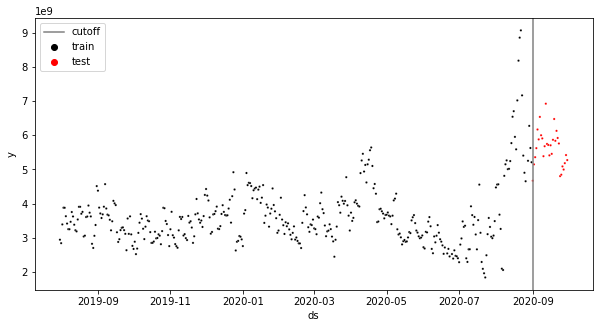

In [238]:
#@title
# for illustration purposes only
cutoff = pd.to_datetime('2020-09-01')
daily_kas_echannel['type'] = daily_kas_echannel['ds'].apply(
    lambda date: 'train' if date < cutoff else 'test')

plt.figure(figsize=(10, 5))
sns.scatterplot(x='ds', y='y', hue='type', s=5,
                palette=['black', 'red'],
                data=daily_kas_echannel)
plt.axvline(x=cutoff, color='gray', label='cutoff')
plt.legend()
plt.show()

In [239]:
train = daily_kas_echannel[daily_kas_echannel['ds'] < cutoff]
test = daily_kas_echannel[daily_kas_echannel['ds'] >= cutoff]

print(f'Train size: {train.shape}')
print(f'Test size: {test.shape}')

Train size: (395, 3)
Test size: (30, 3)


In [240]:
train

,ds,y,type
0,2019-07-31,2.939100e+09,train
1,2019-08-01,2.839150e+09,train
2,2019-08-02,3.387550e+09,train
3,2019-08-03,3.876950e+09,train
4,2019-08-04,3.874250e+09,train
...,...,...,...
390,2020-08-26,4.652250e+09,train
391,2020-08-28,5.249900e+09,train
392,2020-08-29,6.272800e+09,train
393,2020-08-30,5.625400e+09,train


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019



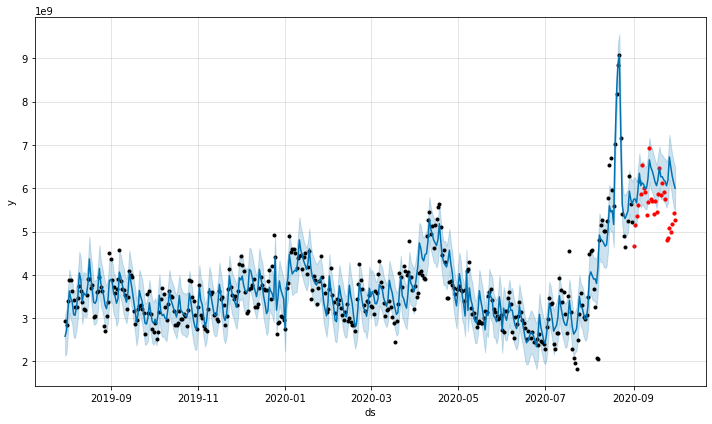

In [241]:
model_final_echannel = Prophet(weekly_seasonality=3,
                                      yearly_seasonality=10,
                                      holidays=holiday_echannel,
                                      changepoint_range=0.8, # default = 0.8 Recommended range: [0.8, 0.95]
                                      changepoint_prior_scale=0.5 # default =0.05 Recommended range: [0.001, 0.5]
                                     )
model_final_echannel.add_country_holidays(country_name='ID')
model_final_echannel.add_seasonality(name='monthly', period=30.5, fourier_order=11)
model_final_echannel.fit(train)

# forecasting
future_final_echannel = model_final_echannel.make_future_dataframe(periods=30, freq='D') # 303 days (test size)
forecast_final_echannel = model_final_echannel.predict(future_final_echannel)

# visualize
fig = model_final_echannel.plot(forecast_final_echannel)
plt.scatter(x=test['ds'], y=test['y'], s=10, color='red')
plt.show()

In [243]:
from sklearn.metrics import mean_squared_log_error
forecast_train = forecast_final_echannel[forecast_final_echannel['ds'] < cutoff]
train_rmsle = mean_squared_log_error(y_true=train['y'],
                                     y_pred=forecast_train['yhat']) ** 0.5
train_rmsle

0.11304722278033351

In [244]:
forecast_test = forecast_final_echannel[forecast_final_echannel['ds'] >= cutoff]
test_rmsle = mean_squared_log_error(y_true=test['y'],
                                    y_pred=forecast_test['yhat']) ** 0.5
test_rmsle

0.12917013158968588

## HyperParameter Tuning Echannel

In this section, we implement a **Grid search algorithm** for model tuning by using for-loop. It builds model for every combination from specified hyperparameters and then evaluate it. The goal is to choose a set of optimal hyperparameters which minimize the forecast error (in this case, smallest RMSLE).

💡 You can use the code template below, please change it as needed in the section marked by `TO DO`.


Click [here](https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning) for a list of recommended hyperparameters to be tuned.

In [454]:
daily_echannel_regressor

,ds,y,kas_kantor
0,2019-07-31,2.939100e+09,1.928940e+09
1,2019-08-01,2.839150e+09,2.492322e+11
2,2019-08-02,3.387550e+09,2.493411e+11
3,2019-08-03,3.876950e+09,2.493411e+11
4,2019-08-04,3.874250e+09,2.608817e+11
...,...,...,...
420,2020-09-26,5.085800e+09,1.123736e+13
421,2020-09-27,4.994300e+09,1.122373e+13
422,2020-09-28,5.181900e+09,1.126813e+13
423,2020-09-29,5.419050e+09,1.134856e+13


In [455]:
from tqdm import tqdm
import itertools
from fbprophet.diagnostics import cross_validation


# Grid search parameters (TO DO: specify possible values)
param_grid = {  
    'changepoint_prior_scale': [0.004, 0.005, 0.006],
    'changepoint_range': [0.8, 0.85, 0.94, 0.95],
    'weekly_seasonality': [3,4,5],
    'yearly_seasonality': [9,10,11]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmsles = []  # Store the RMSLEs for each params here

In [456]:
len(all_params)

108

In [484]:


# Use cross validation to evaluate all parameters
for params in tqdm(all_params):
    # fitting model
    # (TO DO: change the data and add other components: seasonality, holiday, regressor)
    
    model_echannel_regressor = Prophet(**params,
                                       holidays=holiday_echannel,
                                     )
    model_echannel_regressor.add_country_holidays(country_name='ID')
    model_echannel_regressor.add_regressor('kas_kantor')
    model_echannel_regressor.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model_echannel_regressor.fit(daily_echannel_regressor)

    # forecasting
    forecast_echannel_regressor = model_echannel_regressor.predict(future_with_regressor)

    # Expanding window cross validation (TO DO: use different values)
    cv = cross_validation(model_echannel_regressor, initial='110 days', period='5 days', horizon='7 days',
                        parallel='processes')

    # Evaluation metrics: RMSLE
    try:
        rmsle = cv.groupby('cutoff').apply(
        lambda x: mean_squared_log_error(y_true=x['y'],
                                           y_pred=x['yhat']) ** 0.5)
        mean_rmsle = rmsle.mean()
        rmsles.append(mean_rmsle)
    except:
        rmsles.append(1)
        continue
        

    
    
    

  0%|                                                                                          | 0/108 [00:00<?, ?it/s]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000019C94D9A708>
  1%|▊                                                                                 | 1/108 [00:20<36:00, 20.19s/it]INFO:fbproph

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000019C92F16BC8>
  8%|██████▊                                                                           | 9/108 [03:36<41:45, 25.30s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 20

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000019C92EAAAC8>
 16%|████████████▊                                                                    | 17/108 [06:43<36:24, 24.00s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in para

 23%|██████████████████▊                                                              | 25/108 [09:34<28:48, 20.82s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000019C9217CB88>
 24%|███████████████████▌                                                             | 26/108 [09:55<28:21, 20.75s/it]INFO:fbproph

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000019C9493F488>
 31%|█████████████████████████▌                                                       | 34/108 [12:55<26:37, 21.58s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 20

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000019C931352C8>
 39%|███████████████████████████████▌                                                 | 42/108 [15:46<23:08, 21.04s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in para

 46%|█████████████████████████████████████▌                                           | 50/108 [18:35<19:37, 20.30s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000019C947403C8>
 47%|██████████████████████████████████████▎                                          | 51/108 [18:55<19:07, 20.14s/it]INFO:fbproph

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000019C92F53F48>
 55%|████████████████████████████████████████████▎                                    | 59/108 [21:33<16:08, 19.77s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 20

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000019C923412C8>
 62%|██████████████████████████████████████████████████▎                              | 67/108 [24:11<13:28, 19.72s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in para

 69%|████████████████████████████████████████████████████████▎                        | 75/108 [26:49<10:51, 19.74s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000019C933B9748>
 70%|█████████████████████████████████████████████████████████                        | 76/108 [27:09<10:32, 19.76s/it]INFO:fbproph

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000019C92EEBF88>
 78%|███████████████████████████████████████████████████████████████                  | 84/108 [29:48<07:59, 19.97s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 20

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000019C93135B48>
 85%|█████████████████████████████████████████████████████████████████████            | 92/108 [32:26<05:16, 19.75s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in para

 93%|██████████████████████████████████████████████████████████████████████████      | 100/108 [35:06<02:39, 19.98s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

C:\Users\hutom\anaconda3\envs\tensorflow2\lib\site-packages\fbprophet\hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

INFO:fbprophet:Making 63 forecasts with cutoffs between 2019-11-18 00:00:00 and 2020-09-23 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000019C93514D48>
 94%|██████████████████████████████████████████████████████████████████████████▊     | 101/108 [35:26<02:20, 20.01s/it]INFO:fbproph

In [487]:
tuning_results = pd.DataFrame(all_params)
tuning_results['rmsle'] = rmsles
tuning_results.sort_values(by='rmsle')

ValueError: Length of values (216) does not match length of index (108)

In [ ]:
best_params = all_params[np.argmin(rmsles)]
best_params

In [ ]:
model_best = Prophet(**best_params,
                     holidays=holiday_echannel)
model_best.add_country_holidays(country_name='ID')
model_best.add_regressor('kas_kantor')
model_best.add_seasonality(name='monthly', period=31.5, fourier_order=5)
model_best.fit(daily_echannel_regressor)


forecast_echannel_best = model_best.predict(future_with_regressor)


In [ ]:
#Visualize Result
plot_plotly(model_best, forecast_echannel_best)


In [ ]:
# Error with regressor
from sklearn.metrics import mean_squared_log_error
np.sqrt(mean_squared_log_error(daily_kas_echannel.loc[:,'y'], forecast_echannel_best['yhat'].head(425)))


# Create the CSV for submission

In [478]:
forecast_kantor['yhat'].tail(31)

425    1.146093e+13
426    1.147143e+13
427    1.148775e+13
428    1.151439e+13
429    1.154068e+13
430    1.156253e+13
431    1.159927e+13
432    1.170750e+13
433    1.168926e+13
434    1.167888e+13
435    1.167995e+13
436    1.168236e+13
437    1.168637e+13
438    1.171677e+13
439    1.183135e+13
440    1.182687e+13
441    1.182912e+13
442    1.183618e+13
443    1.183868e+13
444    1.184119e+13
445    1.187031e+13
446    1.198020e+13
447    1.196170e+13
448    1.193947e+13
449    1.191900e+13
450    1.190356e+13
451    1.190721e+13
452    1.195662e+13
453    1.210180e+13
454    1.211142e+13
455    1.211840e+13
Name: yhat, dtype: float64

In [479]:
forecast_echannel_best['yhat'].tail(31)

425    4.616587e+09
426    4.891508e+09
427    5.410675e+09
428    5.134476e+09
429    4.926299e+09
430    4.668069e+09
431    4.541382e+09
432    4.434986e+09
433    4.682642e+09
434    5.223055e+09
435    5.073872e+09
436    5.051225e+09
437    4.958214e+09
438    4.939101e+09
439    4.876783e+09
440    5.105597e+09
441    5.584054e+09
442    5.366324e+09
443    5.278265e+09
444    5.098839e+09
445    4.976465e+09
446    4.850992e+09
447    5.081374e+09
448    5.548659e+09
449    5.219058e+09
450    4.970045e+09
451    4.740183e+09
452    4.735977e+09
453    4.676744e+09
454    5.013043e+09
455    5.414806e+09
Name: yhat, dtype: float64

In [480]:
submission = pd.concat([forecast_ekantor_best['yhat'].tail(31), forecast_echannel_best['yhat'].tail(31)], axis=0).reset_index(drop=True)


In [481]:
submission

0     1.156505e+13
1     1.158525e+13
2     1.160967e+13
3     1.164384e+13
4     1.167772e+13
          ...     
57    4.740183e+09
58    4.735977e+09
59    4.676744e+09
60    5.013043e+09
61    5.414806e+09
Name: yhat, Length: 62, dtype: float64

In [482]:
submission.to_csv('both hyperparameter tuning_13 February 2021.csv',index_label='index',header=['value'])